In [1]:
import numpy as np
seed = 42069
np.random.seed(seed)
import pandas as pd
from matplotlib import pyplot as plt
import arviz
import pystan
from scipy import sparse, stats
from typing import Iterable, Union, Callable
from sklearn.model_selection import train_test_split
import altair as alt
from time import time

# Own files
import utils 
import StanClasses

# Load and preprocess data

The data we have is essentially a matrix, where the each row correspond to a person, and each column correspond to a movie. However, the matrix is very sparse and thus data is stored in sparse format (i.e. specified with indices and the corresponding values). 

In [2]:
# Define constants

DATA_DIR = 'ml-100k'
SM_SIMPLE_NAME = 'sm_simple.stan'

In [3]:
from importlib import reload
reload(utils)

df, _, _ = utils.get_ml100k_data(DATA_DIR, subsample_top_users=150, subsample_top_items=20)
df[['user_id', 'item_id']] -= 1

# We are not going to use timestamp, therefore drop it
df.drop('timestamp', axis='columns', inplace=True)

The user ids and item (movie) ids are essentially integer ranges, starting from and 1 to the number of users and items respectively. We don't have the all the unique ids when subsampling users and movies. It becomes problematic ... TODO: Write this

In [4]:
def column_relabler(df: pd.DataFrame, column: str):
    uniques = pd.value_counts(df[column], sort=False).index.values
    n_uniques = len(uniques)

    # Count from 1 to conform with Stan (Stan counts indexes arrays starting at 1)
    num2id = {num_:id_ for num_, id_ in zip(range(0, n_uniques), uniques)}
    id2num = {id_:num_ for num_, id_ in zip(range(0, n_uniques), uniques)}
    
    df[column] = df[column].map(id2num)
    return id2num, num2id

df_num = df.copy()
user2num, num2user = column_relabler(df_num, 'user_id')
item2num, num2item = column_relabler(df_num, 'item_id')

# p, q represents shape of the matrix as if it was dense
p, q = len(user2num), len(item2num)

In [5]:
df_train, df_valtest = train_test_split(df_num, test_size=50)
df_val, df_test = train_test_split(df_valtest, test_size=25)
del df_valtest

# Matrix Factorization 
Want to factorize the dense matrix $X_{n\times m} \approx U_{n\times k}V_{k\times m}$, where the subscripts denotes matrix shapes. The $k$ dimension denotes the user specified embedding dimension. We use different probabilistic models for the components. 


## Model 1: Simple
Ultra simple

$$ U_{ij} \sim N(\mu_u, \sigma_u) $$
$$ V_{ij} \sim N(\mu_v, \sigma_v) $$
$$ X_{ij}\sim N((UV_{ij}), \sigma_x)$$

User defined variables:
$\mu_u, \sigma_u, \mu_v, \sigma_v, \sigma_x$

## Model 2: Non-negative Matrix Factorization

$$ U_{ij}\sim Gamma(a_u, b_u) $$
$$ V_{ij}\sim Gamma(a_v, b_v) $$
$$ X_{ij}\sim Normal(UV_{ij}, \beta)$$
$$ \beta \sim Gamma(a_\beta, b_\beta) $$

User defined variables:
$\mu_u, \sigma_u, \mu_v, \sigma_v, \sigma_x$

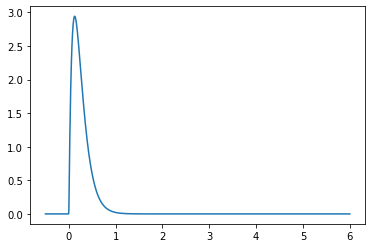

In [120]:
xrange = np.linspace(-0.5,6,1000)

a = 2
y = stats.gamma.pdf(xrange, a=a, scale=1/(4*a))
plt.plot(xrange, y)
plt.show()

## Model 3: ARD

$$ U \sim N(\mu_u, \alpha_u) $$
$$ V \sim N(\mu_v, \psi_v) $$
$$ X_{ij}\sim N((UV)_{ij}, \beta)$$
$$ \beta \sim Gamma(a, b) $$

$$ \alpha_{ij} \sim Gamma(c, d) $$
$$ \psi_{ij} \sim Gamma(e, f) $$

User defined variables:
$a, b, c, d, e, f$

2K samples, 1 chain, 5 thin

X_hat:            2min 30s, 2min 35, 2min 23s

Array of vectors: 4min 21s, 4min 19s

Matrix, no X_hat: 6min 14s, 6min 5s

In [8]:
sm_simple = StanClasses.SimpleFactorizer(10)

t0 = time()
sm_simple.fit(df_train, chains=1, n_jobs=-1, iter=2000, thin=5, control={'max_treedepth':20})
print(time()-t0)

Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


143.96092057228088


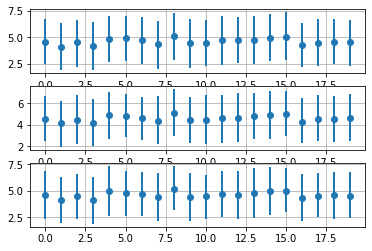

In [77]:
fig, axes = plt.subplots(3)
_ = sm_simple.ci(show=True, ax=axes[0])
_ = sm_simple.ci(show=True, ax=axes[1])
_ = sm_simple.ci(show=True, ax=axes[2])
_ = [ax.grid() for ax in axes]

In [10]:
Us, Vs = sm_simple.Us, sm_simple.Vs

In [11]:
print(sm_simple.mae(df_train))
print(sm_simple.mae(df_val))
print(sm_simple.mae(df_test))

0.6201747113542877
0.7645100083612573
0.8032020940396105


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Test Place

In [12]:
raise ValueError

ValueError: 

In [ ]:
sm_test_code = utils.get_stan_code('sanity.stan')
sm_test = utils.StanModel_cache(sm_test_code, 'test')

In [ ]:
fit_test = sm_test.sampling(algorithm="Fixed_param", chains=4, n_jobs=-1, iter=10)

In [ ]:
A = np.array([[0.674531,0.560879],[-1.82799,0.0132566]])

In [ ]:
A@A

In [ ]:
X_ = 